In [545]:
import numpy as np
import matplotlib.pyplot as plt
from snaptools import snapio
from snaptools import utils
from snaptools import plot_utils
from scipy import stats
import h5py
import conversions as co
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import ImageGrid
from snaptools import CBcm
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import minimize
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [305]:
def line_fit(r, m, b):
    return m*r + b


def rotcur(r, v0, r0):
    return v0*np.min(zip(r/r0, np.ones_like(r)), axis=1)


def rotcur2((x, y), x0, y0, v0, r0):
    r = np.sqrt((x-x0)**2+(y-y0)**2)
    return v0*np.min(zip(r/r0, np.ones_like(r)), axis=1)


def log_halo(r, v0, r0):
    return v0*np.sqrt(0.5*r/(r+r0))

def log_halo2((x, y), x0, y0, v0, r0):
    r = np.sqrt((x-x0)**2+(y-y0)**2)
    return v0*np.sqrt(0.5*r/(r+r0))


def loglog_halo2((x0, y0, v0, r0), x, y):
    r = np.sqrt((x-x0)**2+(y-y0)**2)
    return np.sqrt(np.sum((V-v0*np.sqrt(0.5*r/(r+r0)))**2))

In [188]:
HernOffsets_new = h5py.File('../Data/offSetsHern_new.hdf5', 'r')
DehnenOffsets_new = h5py.File('../Data/offSetsDehnen_new.hdf5', 'r')

In [7]:

velcents2d = np.loadtxt('/usr/users/spardy/coors/data/2dVels/xy_%s.txt' % '45deg')
velcents2d = np.array(velcents2d).reshape(len(velcents2d)/2, 2, order='F')

In [528]:
snap_num = 10
folder = "/usr/users/spardy/coors2/working/Dehnen_LMC/" +\
         "collisions_best/output_Dehnen_smc_45deg/"
snap = snapio.load_snap('{:s}snap_{:03d}.hdf5'.format(folder, snap_num))
halo_pos = DehnenOffsets_best['/stars/45deg']['halo_pos'][snap_num, :]
disk_pos = DehnenOffsets_best['/stars/45deg']['disk_pos'][snap_num, :]
settings = utils.make_settings(first_only= True, com = True, log_scale=True, xlen=10, ylen=10, NBINS=256)

In [529]:
bin_dict = snap.bin_snap(settings)
Z2 = np.log10(bin_dict['Z2'])
Z2[Z2 != Z2] = -10
centerx = (bin_dict['Z2x'][:-1] + bin_dict['Z2x'][1:]) / 2
centery = (bin_dict['Z2y'][:-1] + bin_dict['Z2y'][1:]) / 2
centerX, centerY = np.meshgrid(centerx, centery, indexing='ij')

/usr/users/spardy/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from IPython.kernel.zmq import kernelapp as app


In [530]:
com1, com2, idgal1, idgal2 = snap.center_of_mass('stars')

In [531]:
x = snap.pos['stars'][idgal1, 0]-com1[0]
y = snap.pos['stars'][idgal1, 1]-com1[1]

vavg = snap.vel['stars'][idgal1, :].mean(axis=0)
vx = snap.vel['stars'][idgal1, 0] - vavg[0]
vy = snap.vel['stars'][idgal1, 1] - vavg[1]

velx, xedges, yedges, binnumber = stats.binned_statistic_2d(x,
                                                            y,
                                                            vx,
                                                            statistic='mean', bins=256,
                                                            range=[[-10, 10], [-10, 10]])

vely, xedges, yedges, binnumber = stats.binned_statistic_2d(x,
                                                            y,
                                                            vy,
                                                            statistic='mean', bins=256,
                                                            range=[[-10, 10], [-10, 10]])

centerx = (xedges[:-1] + xedges[1:]) / 2
centery = (yedges[:-1] + yedges[1:]) / 2
Xbins, Ybins = np.meshgrid(centerx, centery, indexing='ij')

R = np.sqrt(Xbins.ravel()**2 + Ybins.ravel()**2)
V = np.sqrt(velx.ravel()**2 + vely.ravel()**2)
Vavg, rbins, binnumber = stats.binned_statistic(R, V, statistic='mean', bins=10, range=[[0, 10]])
Vdisp, rbins, binnumber = stats.binned_statistic(R, V, statistic=np.std, bins=10, range=[[0, 10]])


In [525]:
np.nanmin(V)

1.7513963851887508

In [109]:
np.sum(binnumber == 11)

14068

In [532]:
Z2 = snap.to_cube(parttype='gas', theta=45, write=False, first_only=True,
                  com=True, BINS=256, lengthX=10, lengthY=10)
mom1 = np.zeros((256, 256))
velocities = np.linspace(-200, 200, 100)
for i in xrange(Z2.shape[2]):
    mom1 += Z2[:,:,i]*velocities[i]

mom1 /= np.sum(Z2, axis=2)

/usr/users/spardy/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


In [ ]:
for snap_num in xrange(0,40):
    snap = snapio.load_snap('{:s}snap_{:03d}.hdf5'.format(folder, snap_num))
    com1, com2, idgal1, idgal2 = snap.center_of_mass('stars')
    x = snap.pos['stars'][idgal1, 0]-com1[0]
    y = snap.pos['stars'][idgal1, 1]-com1[1]

    velx, xedges, yedges, binnumber = stats.binned_statistic_2d(x,
                                                                y,
                                                                snap.vel['stars'][idgal1, 0],
                                                                statistic='mean', bins=32,
                                                                range=[[-8, 8], [-8, 8]])

    vely, xedges, yedges, binnumber = stats.binned_statistic_2d(x,
                                                                y,
                                                                snap.vel['stars'][idgal1, 1],
                                                                statistic='mean', bins=32,
                                                               range=[[-8, 8], [-8, 8]])

    centerx = (xedges[:-1] + xedges[1:]) / 2
    centery = (yedges[:-1] + yedges[1:]) / 2
    Xbins, Ybins = np.meshgrid(centerx, centery)

    R = np.sqrt(Xbins.ravel()**2 + Ybins.ravel()**2)
    V = np.sqrt(velx.ravel()**2 + vely.ravel()**2)

    popt, pcov = curve_fit(rotcur2, (Xbins.ravel(), Ybins.ravel()),
                           V, p0=(0.0, 0.0, 120, 8))
    print popt
    print any(np.isinf(pcov).flatten())


(array([ 8.81113024,  1.30402823]), 1)


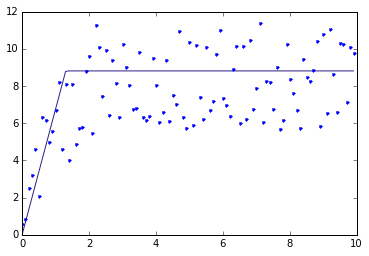

In [294]:
def residual2(p0, x, data, eps_data):
    model = p0[0]*np.min(zip(x/p0[1], np.ones_like(x)), axis=1)
    return (data-model)/eps_data


x = np.arange(0, 10, 0.1)
p0 = [5.7, 2.2]
y = p0[0]*np.min(zip(x/p0[1], np.ones_like(x)), axis=1)+ p0[0]*np.random.rand(len(x))
out = leastsq(residual2, p0, args=(x, y, 1./y))
print out
plt.plot(x,  out[0][0]*np.min(zip(x/out[0][1], np.ones_like(x)), axis=1))
plt.plot(x, y, 'b.') 

0.913398194039
0.173626726732
0.644423631801
0.574712908347
1.05696673849
0.36983825637
0.897687721586
0.241841938511
0.327807830667
0.308505621874
0.835059241603
0.831260281944
0.795632585373
0.637624198921
0.176969534896
0.522626068463
0.73597599594


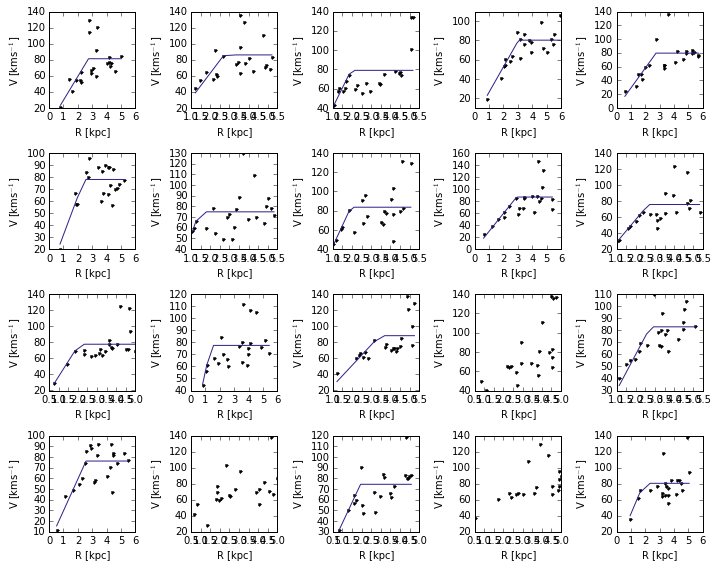

In [547]:
haloCenters = DehnenOffsets_new['/stars/'+group+'/main']['dynamical_center'][10, 0:2]
minv = np.nanmin(V)
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

axes = axes.ravel()

for i in range(20):
    axis = axes[i]
    x_sample = Xbins.ravel()[R < 5]
    y_sample = Ybins.ravel()[R < 5]
    v_sample = V[R < 5] - minv
    UNEQUAL = True
    while UNEQUAL:
        rand_ints = np.random.randint(0, len(x_sample)-1, 22)
        x_pick = x_sample[rand_ints]
        y_pick = y_sample[rand_ints]
        v_pick = v_sample[rand_ints]

        r_pick = np.sqrt(x_pick**2 + y_pick**2)

        if (any(r_pick < 1) and
            any((r_pick > 1)*(r_pick < 2)) and
            any((r_pick > 2)*(r_pick < 3)) and
            any((r_pick > 3)*(r_pick < 4)) and
            any((r_pick > 4)*(r_pick < 5))):
            UNEQUAL = False
        
    rs = np.argsort(r_pick)

    x_pick = x_pick[rs]
    y_pick = y_pick[rs]
    r_pick = r_pick[rs]
    v_pick = v_pick[rs]

    axis.set_xlabel('R [kpc]')
    axis.set_ylabel(r'V [kms$^{-1}$]')

    try:
        popt, pcov = curve_fit(rotcur2, (x_pick, y_pick), v_pick, p0=[0.0, 0.0, 70, 2])
    except RuntimeError:
        axis.plot(r_pick, v_pick, 'k.')
        continue
        
    if not any(np.isinf(pcov).flatten()):
        x, y = popt[0], popt[1]
        print np.sqrt((haloCenters[0]-x)**2 + (y-haloCenters[1])**2)
        r_pick = np.sqrt((x_pick-x)**2 + (y_pick-y)**2)
                
        rs = np.argsort(r_pick)

        x_pick = x_pick[rs]
        y_pick = y_pick[rs]
        r_pick = r_pick[rs]
        v_pick = v_pick[rs]
        axis.plot(r_pick, v_pick, 'k.')
        axis.plot(r_pick,  rotcur2((x_pick, y_pick), popt[0], popt[1], popt[2], popt[3]))
    else:
        axis.plot(r_pick, v_pick, 'k.')

plt.tight_layout()
fig.savefig('../../Offsets_paper/plots/Fitting_Example.pdf', dpi=600, bbox_inches='tight')

[ 70.   2.]
inf


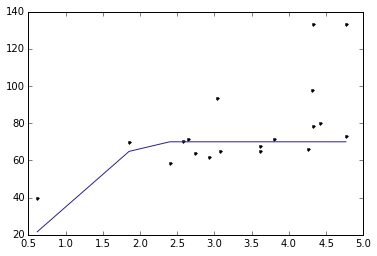

In [534]:
#plt.plot(R, V, 'k.')
#plt.errorbar(rbins[1:], Vavg, yerr=Vdisp, color='red', zorder=10)
#plt.plot(np.convolve(V[np.argsort(R)], np.ones((10,))/10., mode='valid'))
r_sample = R[R < 5]
v_sample = V[R < 5] - minv

rand_ints = np.random.randint(0, len(r_sample)-1, 20)
r_sample = r_sample[rand_ints]
v_sample = v_sample[rand_ints]

rs = np.argsort(r_sample)
 
r_sample = r_sample[rs]
v_sample = v_sample[rs]

plt.plot(r_sample, v_sample, 'k.')

popt, pcov = curve_fit(rotcur, r_sample, v_sample, p0=[70, 2])

print popt
print pcov
plt.plot(r_sample,  rotcur(r_sample, popt[0], popt[1]))


## Multiple Snapshots - One Simulation

/usr/users/spardy/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:42: RuntimeWarning: invalid value encountered in log10


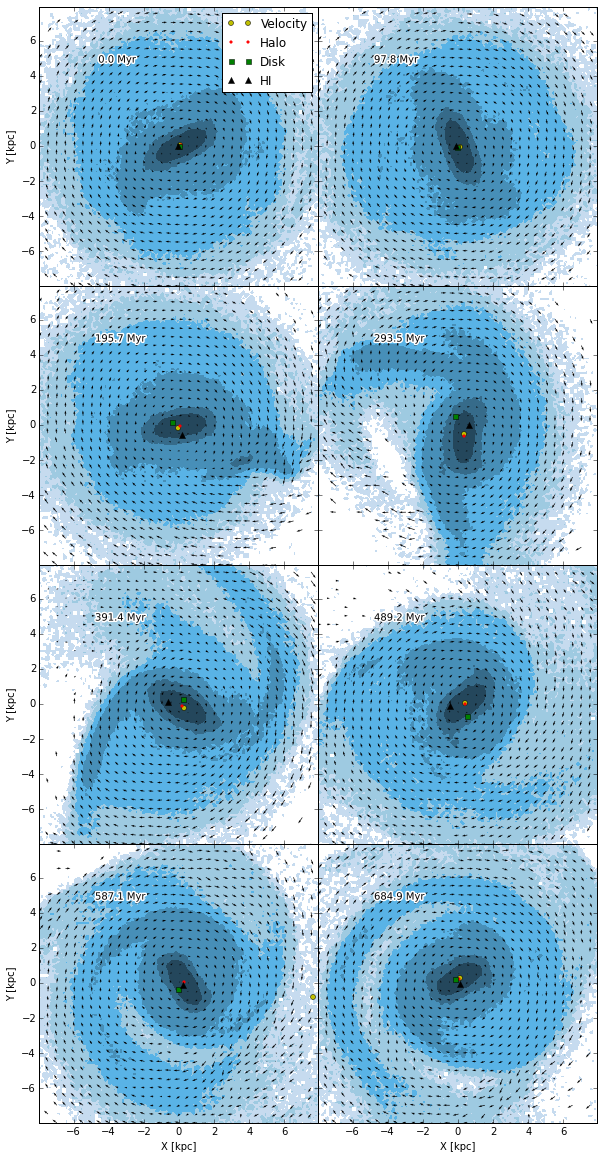

In [15]:
settings = utils.make_settings()
settings['xlen'] = 8
settings['ylen'] = 8
settings['in_min'] = -0.2834#+eps
settings['in_max'] = 2
settings['first_only'] = True
settings['com'] = True
settings['plotDiskCOM'] = False
settings['plotPotMin'] = False
settings['plotCompanionCOM'] = True
settings['NBINS'] = 128
cmap = CBcm.make_color_maps()[0]['SBBl'] #gnuplot'#CBcm.make_color_maps()[0]['OrbG']
cmap.set_under('white')
cmap.set_over('black')
settings['colormap'] = cmap 

UnitTime_in_Gyr = 0.9784620750887875  # standard Gadget Units

folder = "/usr/users/spardy/coors2/hpc_backup/working/Gas/Dehnen_LMC/" +\
         "collisions_best/output_Dehnen_smc_45deg/"
fig = plt.figure(1, figsize=(10.0, 20.0))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                  nrows_ncols=(4, 2),
                 axes_pad=0.0,
                 share_all=True,
                 label_mode='L')

panels = range(0, 32, 4) 

for j, (i, axis) in enumerate(zip(panels, grid)):
    if (j > 0) and (j%2 > 0):
        xticks = axis.xaxis.get_major_ticks()
        xticks[0].label1.set_visible(False)
    if (j > 0) and (j%2 == 0):
        yticks = axis.yaxis.get_major_ticks()
        yticks[-1].label1.set_visible(False)

    snap = snapio.load_snap('{:s}snap_{:03d}.hdf5'.format(folder, i))
    halo_pos = DehnenOffsets_best['/stars/45deg']['halo_pos'][i, :]
    disk_pos = DehnenOffsets_best['/stars/45deg']['disk_pos'][i, :]

    bin_dict = snap.bin_snap(settings)
    Z2 = np.log10(bin_dict['Z2'])
    Z2[Z2 != Z2] = -10
    centerx = (bin_dict['Z2x'][:-1] + bin_dict['Z2x'][1:]) / 2
    centery = (bin_dict['Z2y'][:-1] + bin_dict['Z2y'][1:]) / 2
    centerX, centerY = np.meshgrid(centerx, centery)

    com1, com2, idgal1, idgal2 = snap.center_of_mass('stars')
    
    x = snap.pos['stars'][idgal1, 0]-com1[0]
    y = snap.pos['stars'][idgal1, 1]-com1[1]

    vavg = snap.vel['stars'][idgal1, :].mean(axis=0)
    vx = snap.vel['stars'][idgal1, 0] - vavg[0]
    vy = snap.vel['stars'][idgal1, 1] - vavg[1]

    velx, xedges, yedges, binnumber = stats.binned_statistic_2d(x,
                                                                y,
                                                                vx,
                                                                statistic='mean', bins=256,
                                                                range=[[-8, 8], [-8, 8]])

    vely, xedges, yedges, binnumber = stats.binned_statistic_2d(x,
                                                                y,
                                                                vy,
                                                                statistic='mean', bins=256,
                                                               range=[[-8, 8], [-8, 8]])

    centerx = (xedges[:-1] + xedges[1:]) / 2
    centery = (yedges[:-1] + yedges[1:]) / 2
    Xbins, Ybins = np.meshgrid(centerx, centery)

    R = np.sqrt(Xbins.flatten()**2 + Ybins.flatten()**2)
    V = np.sqrt(velx.flatten()**2 + vely.flatten()**2)
    Vavg, rbins, binnumber = stats.binned_statistic(R, V, statistic='mean')
    Vdisp, rbins, binnumber = stats.binned_statistic(R, V, statistic=np.std)
    custom_plot(bin_dict, axis, settings)
    #axis.pcolormesh(centerY, centerX, Z2.T, vmin=0, cmap='Blues')
    axis.quiver(centery[::8], centerx[::8], vely[::8, ::8], velx[::8, ::8])
    axis.plot(Xbins.flatten()[np.nanargmin(V)],
              Ybins.flatten()[np.nanargmin(V)], 'yo', ms=5, label='Velocity')
    axis.plot(halo_pos[1], halo_pos[0], 'r.', ms=5, label='Halo')
    axis.plot(disk_pos[1], disk_pos[0], 'gs', ms=5, label='Disk')
    axis.plot(velcents2d[i, 1], velcents2d[i, 0], 'k^', label='HI')
    snaphead = snap.header
    snaptime = snaphead['time']
    
    if j == 0:
        lgd = axis.legend()
        lgd.get_frame().set_facecolor('White')

    time = snaptime * co.UnitTime_in_Gyr * 1000.0
    txt = axis.annotate("%4.1f Myr" % (time),
                        fontsize=10,
                        xy=(.2, .8), xycoords='axes fraction',
                        textcoords='axes fraction',
                        xytext=(.2, .8), color='black')
    axis.set_xlabel('X [kpc]', fontsize=10)
    axis.set_ylabel('Y [kpc]', fontsize=10)
    txt.set_path_effects([PathEffects.withStroke(linewidth=3,
                                                 foreground="w")])
    
#plt.savefig('./multi_velfields.pdf', dpi=600)

##Multiple Simulations - One snapshot

-0.5859375 0.4296875
-0.5078125 0.8203125
-0.0390625 0.5859375
0.0390625 0.6640625


/usr/users/spardy/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:44: RuntimeWarning: invalid value encountered in log10


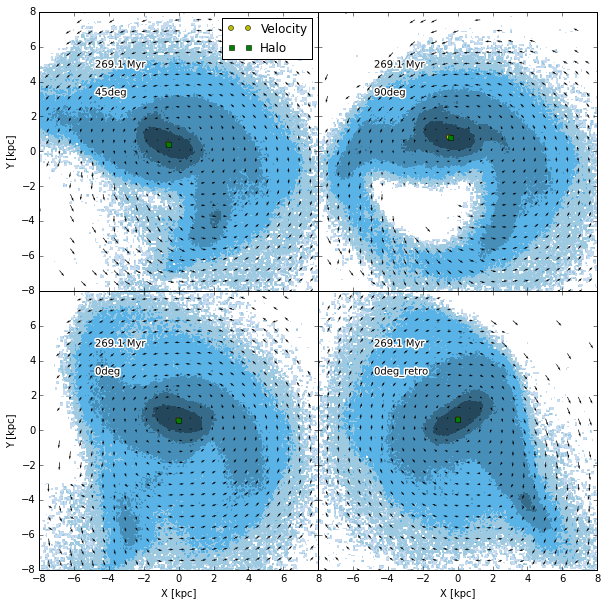

In [189]:
settings = utils.make_settings()
settings['xlen'] = 10
settings['ylen'] = 10
settings['in_min'] = -0.2834#+eps
settings['in_max'] = 2
settings['first_only'] = True
settings['com'] = True
settings['plotDiskCOM'] = False
settings['plotPotMin'] = False
settings['plotCompanionCOM'] = True
settings['NBINS'] = 256
cmap = CBcm.make_color_maps()[0]['SBBl'] #gnuplot'#CBcm.make_color_maps()[0]['OrbG']
cmap.set_under('white')
cmap.set_over('black')
settings['colormap'] = cmap 

UnitTime_in_Gyr = 0.9784620750887875  # standard Gadget Units

folder = "/usr/users/spardy/coors2/hpc_backup/working/Gas/Dehnen_LMC/" +\
         "collisions_best"
orbits = ["45deg", "90deg", "0deg", "0deg_retro"]

fig = plt.figure(1, figsize=(10.0, 10.0))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                  nrows_ncols=(2, 2),
                 axes_pad=0.0,
                 share_all=True,
                 label_mode='L')

panel = 11

for j, (orbit, axis) in enumerate(zip(orbits, grid)):
    if (j > 0) and (j%2 > 0):
        xticks = axis.xaxis.get_major_ticks()
        xticks[0].label1.set_visible(False)
    if (j > 0) and (j%2 == 0):
        yticks = axis.yaxis.get_major_ticks()
        yticks[-1].label1.set_visible(False)

    snap = snapio.load_snap('{:s}/output_Dehnen_smc_{:s}/snap_{:03d}.hdf5'.format(folder, orbit, panel))
    halo_pos = DehnenOffsets_best['/stars/%s' % orbit]['halo_pos'][i, :]
    disk_pos = DehnenOffsets_best['/stars/%s' % orbit]['disk_pos'][i, :]

    bin_dict = snap.bin_snap(settings)
    Z2 = np.log10(bin_dict['Z2'])
    Z2[Z2 != Z2] = -10
    centerx = (bin_dict['Z2x'][:-1] + bin_dict['Z2x'][1:]) / 2
    centery = (bin_dict['Z2y'][:-1] + bin_dict['Z2y'][1:]) / 2
    centerX, centerY = np.meshgrid(centerx, centery)

    com1, com2, idgal1, idgal2 = snap.center_of_mass('stars')
    
    x = snap.pos['stars'][idgal1, 0]-com1[0]
    y = snap.pos['stars'][idgal1, 1]-com1[1]

    vavg = snap.vel['stars'][idgal1, :].mean(axis=0)
    vx = snap.vel['stars'][idgal1, 0] - vavg[0]
    vy = snap.vel['stars'][idgal1, 1] - vavg[1]

    velx, xedges, yedges, binnumber = stats.binned_statistic_2d(x,
                                                                y,
                                                                vx,
                                                                statistic='mean', bins=256,
                                                                range=[[-10, 10], [-10, 10]])

    vely, xedges, yedges, binnumber = stats.binned_statistic_2d(x,
                                                                y,
                                                                vy,
                                                                statistic='mean', bins=256,
                                                               range=[[-10, 10], [-10, 10]])

    centerx = (xedges[:-1] + xedges[1:]) / 2
    centery = (yedges[:-1] + yedges[1:]) / 2
    Xbins, Ybins = np.meshgrid(centerx, centery, indexing='ij')

    R = np.sqrt(Xbins.ravel()**2 + Ybins.ravel()**2)
    V = np.sqrt(velx.ravel()**2 + vely.ravel()**2)
    Vavg, rbins, binnumber = stats.binned_statistic(R, V, statistic='mean')
    Vdisp, rbins, binnumber = stats.binned_statistic(R, V, statistic=np.std)
    custom_plot(bin_dict, axis, settings)

    axis.quiver(Xbins[::8, ::8].ravel(), Ybins[::8, ::8].ravel(), velx[::8, ::8].ravel(), vely[::8, ::8].ravel())
    axis.plot(Xbins.ravel()[np.nanargmin(V)],
              Ybins.ravel()[np.nanargmin(V)], 'yo', ms=5, label='Velocity')
    print Xbins.ravel()[np.nanargmin(V)], Ybins.ravel()[np.nanargmin(V)]

    haloCenters = DehnenOffsets_new['/stars/'+orbit+'/main']['dynamical_center'][panel, 0:2]
    axis.plot(haloCenters[0], haloCenters[1], 'gs', ms=5, label='Halo')
    snaphead = snap.header
    snaptime = snaphead['time']
    
    axis.set_xlim([-8, 8])
    axis.set_ylim([-8, 8])
    
    if j == 0:
        lgd = axis.legend()
        lgd.get_frame().set_facecolor('White')

    time = snaptime * co.UnitTime_in_Gyr * 1000.0
    txt = axis.annotate("%4.1f Myr" % (time),
                        fontsize=10,
                        xy=(.2, .8), xycoords='axes fraction',
                        textcoords='axes fraction',
                        xytext=(.2, .8), color='black')
    axis.set_xlabel('X [kpc]', fontsize=10)
    axis.set_ylabel('Y [kpc]', fontsize=10)
    txt.set_path_effects([PathEffects.withStroke(linewidth=3,
                                                 foreground="w")])
    txt = axis.annotate("%s" % orbit,
                    fontsize=10,
                    xy=(.2, .7), xycoords='axes fraction',
                    textcoords='axes fraction',
                    xytext=(.2, .7), color='black')
    txt.set_path_effects([PathEffects.withStroke(linewidth=3,
                                                 foreground="w")])

In [174]:
V2d = np.sqrt(velx**2 + vely**2)

In [181]:
min_loc = np.nanargmin(V)
print min_loc, min_loc // 256, min_loc % 256
print V2d[124, 127], V2d[127, 124]

print np.nanargmin(V2d)

print Xbins[124, 127], Ybins[124, 127]
print Xbins.ravel()[31871], Ybins.ravel()[31871]


31871 124 127
2.86044064393 12.6850586728
31871
-0.21875 -0.03125
-0.21875 -0.03125


In [103]:
def custom_plot(bin_dict, axis, settings):
    Z2 = bin_dict['Z2']
    centerx = (bin_dict['Z2x'][:-1] + bin_dict['Z2x'][1:]) / 2
    centery = (bin_dict['Z2y'][:-1] + bin_dict['Z2y'][1:]) / 2
    centerY, centerX = np.meshgrid(centerx, centery)
    
    xmax = 8
    ymax = 8
    
    levels = np.linspace(settings['in_min'], settings['in_max'], 20)
    levels = np.append(levels, 2.8)

    im = axis.contourf(centerX, centerY, Z2,
                       colors = [(198/255.,219/255.,239/255., 1),
                                 (158/255.,202/255.,225/255., 1),
                                 cmap(0), cmap(0.2), cmap(0.4), cmap(0.6), cmap(0.8), cmap(1)],
                       vmin=settings['in_min'],
                      levels=levels[[0, 4, 8, 12, 16, -2, -1]], label='Stellar Density')

            
    return im

In [187]:
basepath = "/usr/users/spardy/coors2/hpc_backup/working/Gas/Dehnen_LMC/collisions_best"
orbits = ['45deg', '90deg', '0deg', '0deg_retro']
with h5py.File('/usr/users/spardy/Dropbox/notebooks/Data/offsetsStellarVelocity.hdf5', 'w') as f:
    for orbit in orbits:
        folder = "{:s}/output_Dehnen_smc_{:s}".format(basepath, orbit)
        subgrp = f.create_group(orbit)
        time_dset = subgrp.create_dataset('time', (82, ))
        velocity_dset = subgrp.create_dataset('velocity_centers', (82, 2))
        times = np.empty((82, ))
        velocity_centers = np.empty((82, 2))
        for i in xrange(82):
            snap = snapio.load_snap('{:s}/snap_{:03d}.hdf5'.format(folder, i))
            snaphead = snap.header
            times[i] = snaphead['time']

            com1, com2, idgal1, idgal2 = snap.center_of_mass('stars')

            x = snap.pos['stars'][idgal1, 0]-com1[0]
            y = snap.pos['stars'][idgal1, 1]-com1[1]
            vavg = snap.vel['stars'][idgal1, :].mean(axis=0)
            vx = snap.vel['stars'][idgal1, 0] - vavg[0]
            vy = snap.vel['stars'][idgal1, 1] - vavg[1]

            velx, xedges, yedges, binnumber = stats.binned_statistic_2d(x,
                                                                        y,
                                                                        vx,
                                                                        statistic='mean', bins=256,
                                                                        range=[[-10, 10], [-10, 10]])

            vely, xedges, yedges, binnumber = stats.binned_statistic_2d(x,
                                                                        y,
                                                                        vy,
                                                                        statistic='mean', bins=256,
                                                                        range=[[-10, 10], [-10, 10]])

            centerx = (xedges[:-1] + xedges[1:]) / 2
            centery = (yedges[:-1] + yedges[1:]) / 2
            Xbins, Ybins = np.meshgrid(centerx, centery, indexing='ij')

            V = np.sqrt(velx.ravel()**2 + vely.ravel()**2)

            velocity_centers[i, :] = Xbins.ravel()[np.nanargmin(V)], Ybins.ravel()[np.nanargmin(V)]
            
        time_dset[:] = times
        velocity_dset[:] = velocity_centers 

In [196]:
with h5py.File('../Data/offsetsStellarVelocity.hdf5', 'r') as f:
    group = '0deg_retro'
    stellar_velocities = f["{:s}/velocity_centers".format(group)][()]
    stellar_velocities_time = f["{:s}/time".format(group)][()]
    
    times = DehnenOffsets_new['/stars/'+group+'/main']['time'][()]
    haloCenters = DehnenOffsets_new['/stars/'+group+'/main']['dynamical_center'][:, 0:2]
        
    velocity_dist = np.sqrt(np.sum((stellar_velocities-haloCenters)**2, axis=1))
    
    velocity_dist[velocity_dist > 2] = np.nan

    print np.nanargmax(velocity_dist), np.nanmax(velocity_dist)



15 0.200512


In [541]:
def prepare_centers(group):
    with h5py.File('../Data/centers_stellar_fitting.hdf5', 'r') as f:
        errors = f['Dehnen/%s'%group]['errors'][()]
        centers = f['Dehnen/%s'%group]['centers'][()]
    
    for i in xrange(82):
        bad_ind = ~(errors[i, :, 0] < 0.5) * ~(errors[i, :, 1] < 0.5)
        centers[i, bad_ind, :] = [np.nan, np.nan]
    
    cent_avg = np.empty((82, 2, 2))
    cent_avg[:, 0, :] = np.nanmean(centers, axis=1)
    cent_avg[:, 1, :] = np.nanstd(centers, axis=1)
    
    return cent_avg

In [535]:
with h5py.File('../Data/centers_stellar_fitting.hdf5', 'r') as f:
    errors = f['Dehnen/45deg']['errors'][()]
    centers = f['Dehnen/45deg']['centers'][()]

In [536]:
for i in xrange(82):
    bad_ind = ~(errors[i, :, 0] < 0.5) * ~(errors[i, :, 1] < 0.5)
    centers[i, bad_ind, :] = [np.nan, np.nan]

In [537]:
cent_avg = np.empty((82, 2, 2))
cent_avg[:, 0, :] = np.nanmean(centers, axis=1)
cent_avg[:, 1, :] = np.nanstd(centers, axis=1)


In [538]:
haloCenters = DehnenOffsets_new['/stars/'+group+'/main']['dynamical_center'][:, 0:2]
offsets = np.empty((82, 10000))
for i in xrange(82):
    offsets[i, :] = np.sqrt((centers[i, :, 0]-haloCenters[i, 0])**2 +
                            (centers[i, :, 1]-haloCenters[i, 1])**2)      

offsets_avg = np.zeros((82, 3))
offsets_avg[:, 0] = np.nanmean(offsets, axis=1)
offsets_avg[:, 1] = np.nanpercentile(offsets, 16, axis=1)
offsets_avg[:, 2] = np.nanpercentile(offsets, 84, axis=1)

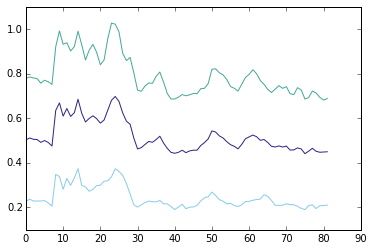

In [539]:
plt.plot(offsets_avg[:, 0])
plt.plot(offsets_avg[:, 1])
plt.plot(offsets_avg[:, 2])


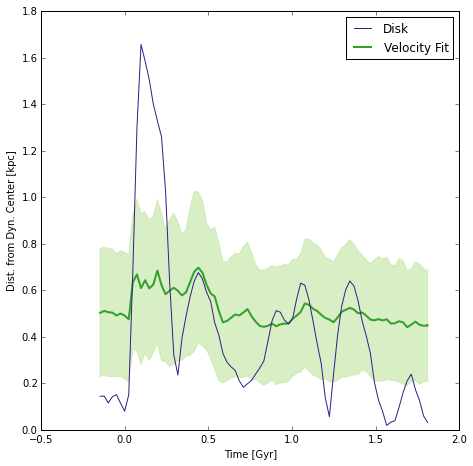

In [540]:
fig, axis = plt.subplots(1, figsize=(7.5, 7.5))
colors = ['#332288', '#CC6677', '#6699CC', '#117733']

encounter_time = 0.15
diskdyn_dist = np.sqrt(np.sum((DehnenOffsets_new['stars/45deg/main']['disk_pos'][:, :, 0] -
                DehnenOffsets_new['stars/45deg/main']['dynamical_center'][:, 0:2])**2, axis=1))

time = DehnenOffsets_new['stars/45deg/main']['time'][()]

time -= encounter_time
time *= co.UnitTime_in_Gyr

axis.plot(time, diskdyn_dist, color=colors[0], label='Disk')
axis.plot(time, offsets_avg[:, 0], color='#33a02c', zorder=-1,
          linewidth=2, label='Velocity Fit')
axis.fill_between(time, offsets_avg[:, 1], offsets_avg[:, 2], color='#b2df8a',
                  zorder=-1, alpha=0.5, label=r'1$\sigma$')
axis.legend()
axis.set_xlabel('Time [Gyr]')
axis.set_ylabel('Dist. from Dyn. Center [kpc]')
#plt.savefig('/d/www/spardy/images/vel_fit_centers.pdf', dpi=600)

/usr/users/spardy/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:26: RuntimeWarning: invalid value encountered in log10


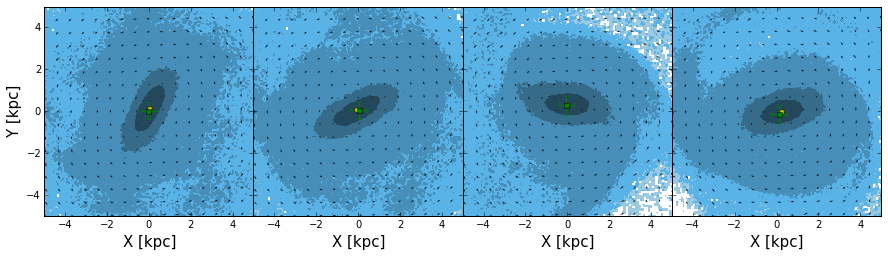

In [524]:
fig = plt.figure(1, figsize=(15.0, 5.0))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                  nrows_ncols=(1, 4),
                 axes_pad=0.0,
                 share_all=True,
                 label_mode='L',
                 cbar_mode='none')


panels = [0, 6, 18, 33]

folder = "/usr/users/spardy/coors2/working/Dehnen_LMC/" +\
         "collisions_best/output_Dehnen_smc_45deg/"

for j, (i, axis) in enumerate(zip(panels, grid)):
    if j > 0:
        xticks = axis.xaxis.get_major_ticks()
        xticks[0].label1.set_visible(False)
    
    
    snap = snapio.load_snap('{:s}snap_{:03d}.hdf5'.format(folder, i))
    halo_pos = DehnenOffsets_best['/stars/45deg']['halo_pos'][i, :]
    disk_pos = DehnenOffsets_best['/stars/45deg']['disk_pos'][i, :]
    settings = utils.make_settings(first_only= True, com = True, log_scale=True, xlen=10, ylen=10, NBINS=256)

    bin_dict = snap.bin_snap(settings)
    Z2 = np.log10(bin_dict['Z2'])
    Z2[Z2 != Z2] = -10
    centerx = (bin_dict['Z2x'][:-1] + bin_dict['Z2x'][1:]) / 2
    centery = (bin_dict['Z2y'][:-1] + bin_dict['Z2y'][1:]) / 2
    centerX, centerY = np.meshgrid(centerx, centery, indexing='ij')

    com1, com2, idgal1, idgal2 = snap.center_of_mass('stars')

    x = snap.pos['stars'][idgal1, 0]-com1[0]
    y = snap.pos['stars'][idgal1, 1]-com1[1]

    vavg = snap.vel['stars'][idgal1, :].mean(axis=0)
    vx = snap.vel['stars'][idgal1, 0] - vavg[0]
    vy = snap.vel['stars'][idgal1, 1] - vavg[1]

    velx, xedges, yedges, binnumber = stats.binned_statistic_2d(x,
                                                                y,
                                                                vx,
                                                                statistic='mean', bins=256,
                                                                range=[[-10, 10], [-10, 10]])

    vely, xedges, yedges, binnumber = stats.binned_statistic_2d(x,
                                                                y,
                                                                vy,
                                                                statistic='mean', bins=256,
                                                                range=[[-10, 10], [-10, 10]])

    centerx = (xedges[:-1] + xedges[1:]) / 2
    centery = (yedges[:-1] + yedges[1:]) / 2
    Xbins, Ybins = np.meshgrid(centerx, centery, indexing='ij')

    R = np.sqrt(Xbins.ravel()**2 + Ybins.ravel()**2)
    V = np.sqrt(velx.ravel()**2 + vely.ravel()**2)

    custom_plot(bin_dict, axis, settings)
    #im = axis.contour(centerX, centerY, mom1, cmap='gnuplot', vmin=-100, vmax=100)
    Q = axis.quiver(centerX[::8, ::8].ravel(), centerY[::8, ::8].ravel(), velx[::8, ::8].ravel(), vely[::8, ::8].ravel())


    axis.set_xlabel('X [kpc]', fontsize=15)
    axis.set_ylabel('Y [kpc]', fontsize=15)
    axis.set_ylim([-5, 5])
    axis.set_xlim([-5, 5])
    axis.plot(Xbins.ravel()[np.nanargmin(V)],
                  Ybins.ravel()[np.nanargmin(V)], 'yo', ms=5, label='Minimum Velocity')

    axis.errorbar(cent_avg[i, 0, 0], cent_avg[i, 0, 1], xerr=cent_avg[i, 1, 0], yerr=cent_avg[i, 1, 1],
                  color='green', marker='s', ms=5, label='Fitted Center')
outname = '../../Offsets_paper/plots/vel_centers_panels.pdf'
#plt.tight_layout()
fig.savefig(outname, dpi=600)